# Testing a superfast way to create huge graphs (aka SuperOnion)

SuperOnion uses encodings of values per column if they aren't numerical, to allow a more efficient way of loading bulk additions to graph-tool via numpy and the add_edge_list method.

This notebook tests it to see how it scales to millions of nodes, with many different types of node or edge properties, and missing values.

Some things that are _not_ yet accounted for:
- nested properties (e.g. 'ABC|XYZ')

The approximate results from the tests here (not replicated or tried on different machines, but ballpark):
- medium run: 12 seconds
  - 1m nodes, 5m edges, 12 node properties per node (layer, node_id, and 10 others: 5 ints, 3 floats, 2 categoricals), 10 edge properties per edge (also 5 ints, 3 floats, 2 categoricals)
- large run: 95 seconds
  - 10m nodes, 20m edges, 12 node properties per node (layer, node_id, and 10 others: 5 ints, 3 floats, 2 categoricals), 10 edge properties per edge (also 5 ints, 3 floats, 2 categoricals)

In [1]:
import lipinet.databases  # Import the module
import graph_tool as gt
import importlib

# Reload the module to ensure changes are picked up
importlib.reload(lipinet)

# Now you can use your function after reloading the module
from lipinet.databases import download_and_load_data, get_prior_knowledge
from lipinet.network import MultilayerNetwork, MultilayerNetworkGraphTool, MultilayerNetworkFast, MultilayerNetworkSuperFast
from lipinet.supernetwork import SuperOnion
from lipinet.visualisation import set_node_sizes_and_text_by_depth

import pandas as pd
import numpy as np

import graph_tool
from graph_tool.all import graph_draw, bfs_iterator

In [2]:
def run_scaleup_test(df_nodes, df_edges, onion_object, 
                     node_prop_cols=['node_prop_1', 'node_prop_2'], 
                     edge_prop_cols=['edge_prop_1', 'edge_prop_2'],
                     drop_na=True):

    # Show snippet of the data and shape
    for df in [df_nodes, df_edges]:
        display(df.head())
        print(df.shape)    


    # Add vertices from the DataFrame
    onion_object.add_vertices_from_dataframe(
        df_nodes,
        id_col='node_id',      # Original node IDs (strings)
        layer_col='layer',     # Original layer names (strings)
        property_cols=node_prop_cols,
        drop_na=drop_na           # Drop rows with missing IDs or layers
    )

    # Add edges from the DataFrame
    onion_object.add_edges_from_dataframe(
        df_edges,
        source_id_col='source_id',
        source_layer_col='source_layer',
        target_id_col='target_id',
        target_layer_col='target_layer',
        property_cols=edge_prop_cols,
        drop_na=drop_na
    )

    # Display graph summary
    summary_info = onion_object.summary()
    print("\nGraph Summary:")
    for key, value in summary_info.items():
        if isinstance(value, list):
            print(f"{key}:")
            for item in value:
                print(f"  - {item}")
        else:
            print(f"{key}: {value}")

    # List all vertex properties
    vertex_props_df = onion_object.list_vertex_properties()
    print("\nVertex Properties:")
    print(vertex_props_df)

    # List all edge properties
    edge_props_df = onion_object.list_edge_properties()
    print("\nEdge Properties:")
    print(edge_props_df)

    # View properties of a specific node 
    node_properties = onion_object.view_node_properties_by_names('LayerA', '1', verbose=True)

    # Retrieve an edge property 
    edge_prop_value = onion_object.get_edge_property_by_names('LayerA', '1', 'LayerB', '2', 'edge_prop_1', verbose=True)

    # Retrieve all edge properties between two nodes
    all_edge_props = onion_object.get_edge_property_by_names('LayerA', '1', 'LayerB', '2', verbose=True)


## Small Test

In [3]:
# Sample data for nodes
node_data = {
    'node_id': ['1', '2', '3'],          # String IDs
    'layer': ['LayerA', 'LayerB', 'LayerA'],  # String layers
    'node_prop_1': [10.5, 20.3, 30.1],   # Numerical properties (float)
    'node_prop_2': [100, 200, 300]        # Numerical properties (int)
}
df_nodes_small = pd.DataFrame(node_data)

# Sample data for edges
edge_data = {
    'source_id': ['1', '2'],              # String IDs
    'source_layer': ['LayerA', 'LayerB'], # String layers
    'target_id': ['2', '3'],              # String IDs
    'target_layer': ['LayerB', 'LayerA'], # String layers
    'edge_prop_1': [1.1, 2.2],            # Numerical properties (float)
    'edge_prop_2': [10, 20]                # Numerical properties (int)
}
df_edges_small = pd.DataFrame(edge_data)

node_props = [item for item in df_nodes_small.columns if item.startswith('node_prop')]
edge_props = [item for item in df_edges_small.columns if item.startswith('edge_prop')]

superonion_small = SuperOnion()

In [4]:
run_scaleup_test(df_nodes=df_nodes_small,
                 df_edges=df_edges_small,
                 onion_object=superonion_small,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2
0,1,LayerA,10.5,100
1,2,LayerB,20.3,200
2,3,LayerA,30.1,300


(3, 4)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2
0,1,LayerA,2,LayerB,1.1,10
1,2,LayerB,3,LayerA,2.2,20


(2, 6)

Graph Summary:
Number of Vertices: 3
Number of Edges: 2
Number of Vertex Properties: 4
Number of Edge Properties: 2
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
Edge Properties:
  - edge_prop_1
  - edge_prop_2

Vertex Properties:
  Property Name     Type
0    layer_hash  int64_t
1  node_id_hash  int64_t
2   node_prop_1   double
3   node_prop_2  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1   double
1   edge_prop_2  int32_t

Properties for node (Layer: 'LayerA', Node ID: '1'):
  layer_hash: 0
  node_id_hash: 0
  node_prop_1: 10.5
  node_prop_2: 100
  decoded_layer: LayerA
  decoded_node_id: 1

Edge Property 'edge_prop_1' between (LayerA, '1') and (LayerB, '2'): 1.1

All Edge Properties between (LayerA, '1') and (LayerB, '2'):
  edge_prop_1: 1.1
  edge_prop_2: 10


## Medium test

In [5]:
import pandas as pd
import numpy as np
from graph_tool.all import Graph
import pickle

# ---------------------------
# Generate Test DataFrames
# ---------------------------

print("Generating Test DataFrames...")

# Set RNG seed for reproducibility
np.random.seed(42)  # Set the seed to a fixed integer

# Parameters
num_nodes = 1_000_000  # 1 million nodes
num_edges = 5_000_000  # 5 million edges
layers = ['Layer_A', 'Layer_B', 'Layer_C', 'Layer_D', 'Layer_E']
categories = ['Category_X', 'Category_Y', 'Category_Z']
node_property_cols = [f'node_prop_{i}' for i in range(1, 11)]  # node_prop_1 to node_prop_10
edge_property_cols = [f'edge_prop_{i}' for i in range(1, 11)]  # edge_prop_1 to edge_prop_10

# Generate node_ids
node_ids = np.array(['node{}'.format(i) for i in range(1, num_nodes + 1)])

# Assign layers to nodes
node_layers = np.random.choice(layers, size=num_nodes)

# Generate node properties
# Integer properties
node_prop_1 = np.random.randint(0, 1000, size=num_nodes).astype('int32')
node_prop_2 = np.random.randint(1000, 2000, size=num_nodes).astype('int32')
node_prop_3 = np.random.randint(2000, 3000, size=num_nodes).astype('int32')
node_prop_4 = np.random.randint(3000, 4000, size=num_nodes).astype('int32')
node_prop_5 = np.random.randint(4000, 5000, size=num_nodes).astype('int32')

# Float properties
node_prop_6 = np.random.uniform(0, 1000, size=num_nodes).astype('float32')
node_prop_7 = np.random.uniform(1000, 2000, size=num_nodes).astype('float32')
node_prop_8 = np.random.uniform(2000, 3000, size=num_nodes).astype('float32')

# Categorical properties
node_prop_9 = np.random.choice(categories, size=num_nodes)
node_prop_10 = np.random.choice(categories, size=num_nodes)

# Create nodes DataFrame
df_nodes = pd.DataFrame({
    'node_id': node_ids,
    'layer': node_layers,
    'node_prop_1': node_prop_1,
    'node_prop_2': node_prop_2,
    'node_prop_3': node_prop_3,
    'node_prop_4': node_prop_4,
    'node_prop_5': node_prop_5,
    'node_prop_6': node_prop_6,
    'node_prop_7': node_prop_7,
    'node_prop_8': node_prop_8,
    'node_prop_9': node_prop_9,
    'node_prop_10': node_prop_10
})

# Optimize data types
df_nodes['node_id'] = df_nodes['node_id'].astype('category')
df_nodes['layer'] = df_nodes['layer'].astype('category')
df_nodes['node_prop_9'] = df_nodes['node_prop_9'].astype('category')
df_nodes['node_prop_10'] = df_nodes['node_prop_10'].astype('category')

df_nodes_medium = df_nodes # to standardise naming with previous test

print("Nodes DataFrame created with shape:", df_nodes_medium.shape)

# Generate edges
source_ids = np.random.choice(node_ids, size=num_edges)
target_ids = np.random.choice(node_ids, size=num_edges)

# Create mapping from node_id to layer
node_id_to_layer = pd.Series(df_nodes.layer.values, index=df_nodes.node_id).to_dict()

# Assign layers based on node IDs
edge_source_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in source_ids])
edge_target_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in target_ids])

# Generate edge properties
# Integer properties
edge_prop_1 = np.random.randint(0, 100, size=num_edges).astype('int16')
edge_prop_2 = np.random.randint(100, 200, size=num_edges).astype('int16')
edge_prop_3 = np.random.randint(200, 300, size=num_edges).astype('int16')
edge_prop_4 = np.random.randint(300, 400, size=num_edges).astype('int16')
edge_prop_5 = np.random.randint(400, 500, size=num_edges).astype('int16')

# Float properties
edge_prop_6 = np.random.uniform(0, 100, size=num_edges).astype('float32')
edge_prop_7 = np.random.uniform(100, 200, size=num_edges).astype('float32')
edge_prop_8 = np.random.uniform(200, 300, size=num_edges).astype('float32')

# Categorical properties
edge_prop_9 = np.random.choice(categories, size=num_edges)
edge_prop_10 = np.random.choice(categories, size=num_edges)

# Create edges DataFrame
df_edges = pd.DataFrame({
    'source_id': source_ids,
    'source_layer': edge_source_layers,
    'target_id': target_ids,
    'target_layer': edge_target_layers,
    'edge_prop_1': edge_prop_1,
    'edge_prop_2': edge_prop_2,
    'edge_prop_3': edge_prop_3,
    'edge_prop_4': edge_prop_4,
    'edge_prop_5': edge_prop_5,
    'edge_prop_6': edge_prop_6,
    'edge_prop_7': edge_prop_7,
    'edge_prop_8': edge_prop_8,
    'edge_prop_9': edge_prop_9,
    'edge_prop_10': edge_prop_10
})

# Optimize data types
df_edges['source_id'] = df_edges['source_id'].astype('category')
df_edges['source_layer'] = df_edges['source_layer'].astype('category')
df_edges['target_id'] = df_edges['target_id'].astype('category')
df_edges['target_layer'] = df_edges['target_layer'].astype('category')
df_edges['edge_prop_9'] = df_edges['edge_prop_9'].astype('category')
df_edges['edge_prop_10'] = df_edges['edge_prop_10'].astype('category')

df_edges_medium = df_edges # to standardise naming with previous test

print("Edges DataFrame created with shape:", df_edges_medium.shape)

# ---------------------------
# Add specific edges for testing
# ---------------------------

# # Define specific edges you want to ensure exist in the graph
# specific_edges = pd.DataFrame({
#     'source_id': ['node359928', 'node823610'],  # Replace with actual node IDs
#     'source_layer': ['Layer_D', 'Layer_A'],
#     'target_id': ['node128516', 'node798629'],
#     'target_layer': ['Layer_D', 'Layer_E'],
#     'edge_prop_1': [25, 30],  # Example property values
#     'edge_prop_2': [35, 40],
#     'edge_prop_3': [45, 50],
#     'edge_prop_4': [55, 60],
#     'edge_prop_5': [65, 70],
#     'edge_prop_6': [75.76, 80.80],
#     'edge_prop_7': [85.86, 90.90],
#     'edge_prop_8': [95.96, 100.100],
#     'edge_prop_9': ['Category_Z', 'Category_Y'],
#     'edge_prop_10': ['Category_X', 'Category_Z']
# })

# Optimize data types for specific_edges
# specific_edges['source_id'] = specific_edges['source_id'].astype('category')
# specific_edges['source_layer'] = specific_edges['source_layer'].astype('category')
# specific_edges['target_id'] = specific_edges['target_id'].astype('category')
# specific_edges['target_layer'] = specific_edges['target_layer'].astype('category')
# specific_edges['edge_prop_9'] = specific_edges['edge_prop_9'].astype('category')
# specific_edges['edge_prop_10'] = specific_edges['edge_prop_10'].astype('category')

# Append specific edges to the edges DataFrame
# df_edges = pd.concat([specific_edges, df_edges], ignore_index=True)

node_props = [item for item in df_nodes_medium.columns if item.startswith('node_prop')]
edge_props = [item for item in df_edges_medium.columns if item.startswith('edge_prop')]

superonion_medium = SuperOnion()


Generating Test DataFrames...
Nodes DataFrame created with shape: (1000000, 12)
Edges DataFrame created with shape: (5000000, 14)


In [6]:
run_scaleup_test(df_nodes=df_nodes_medium,
                 df_edges=df_edges_medium,
                 onion_object=superonion_medium,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2,node_prop_3,node_prop_4,node_prop_5,node_prop_6,node_prop_7,node_prop_8,node_prop_9,node_prop_10
0,node1,Layer_D,284,1197,2874,3725,4703,858.844849,1805.748901,2187.844482,Category_X,Category_X
1,node2,Layer_E,430,1935,2388,3276,4325,756.825623,1347.896118,2316.397949,Category_Z,Category_X
2,node3,Layer_C,945,1212,2511,3574,4261,94.367973,1956.879883,2043.174927,Category_Y,Category_Y
3,node4,Layer_E,405,1977,2728,3287,4040,412.188324,1137.894409,2803.983154,Category_Y,Category_X
4,node5,Layer_E,739,1741,2052,3515,4850,969.274231,1349.678223,2627.374268,Category_Z,Category_Z


(1000000, 12)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2,edge_prop_3,edge_prop_4,edge_prop_5,edge_prop_6,edge_prop_7,edge_prop_8,edge_prop_9,edge_prop_10
0,node206252,Layer_A,node860662,Layer_A,99,156,207,315,436,48.851147,154.910324,214.405975,Category_Y,Category_Z
1,node639425,Layer_D,node509845,Layer_E,71,159,277,307,454,0.841779,146.617432,239.794128,Category_Y,Category_Z
2,node93648,Layer_C,node992976,Layer_D,19,128,208,371,456,29.605192,146.235992,200.754440,Category_Y,Category_X
3,node566658,Layer_C,node419108,Layer_E,47,149,253,379,483,2.823314,159.105331,200.614014,Category_Y,Category_Z
4,node512068,Layer_B,node822872,Layer_D,95,163,247,368,456,76.048004,101.035538,267.903137,Category_Z,Category_X


(5000000, 14)

Graph Summary:
Number of Vertices: 1000000
Number of Edges: 5000000
Number of Vertex Properties: 12
Number of Edge Properties: 10
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
  - node_prop_3
  - node_prop_4
  - node_prop_5
  - node_prop_6
  - node_prop_7
  - node_prop_8
  - node_prop_9
  - node_prop_10
Edge Properties:
  - edge_prop_1
  - edge_prop_2
  - edge_prop_3
  - edge_prop_4
  - edge_prop_5
  - edge_prop_6
  - edge_prop_7
  - edge_prop_8
  - edge_prop_9
  - edge_prop_10

Vertex Properties:
   Property Name     Type
0     layer_hash  int64_t
1   node_id_hash  int64_t
2    node_prop_1  int32_t
3    node_prop_2  int32_t
4    node_prop_3  int32_t
5    node_prop_4  int32_t
6    node_prop_5  int32_t
7    node_prop_6   double
8    node_prop_7   double
9    node_prop_8   double
10   node_prop_9  int32_t
11  node_prop_10  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1  int32_t
1   edge_prop_2  int32_t
2   edge_prop_

Could also view different specific nodes

In [7]:
# # ---------------------------
# # View properties of a specific node
# # ---------------------------

# # Example: View properties of node 'node1' in 'Layer_A'
# node_properties = graph.view_node_properties_by_names('Layer_D', 'node1', verbose=True)

# # ---------------------------
# # Retrieve a specific edge property
# # ---------------------------

# # Example: Retrieve 'edge_prop_1' between ('Layer_D', 'node359928') and ('Layer_D', 'node128516') with verbose output
# edge_prop_value = graph.get_edge_property_by_names(
#     source_layer_name='Layer_D',
#     source_node_id_str='node359928',
#     target_layer_name='Layer_D',
#     target_node_id_str='node128516',
#     prop_name='edge_prop_1',
#     verbose=True
# )

# # ---------------------------
# # Retrieve all edge properties between two nodes
# # ---------------------------

# # Example: Retrieve all edge properties between ('Layer_A', 'node823610') and ('Layer_E', 'node798629') with verbose output
# all_edge_props = graph.get_edge_property_by_names(
#     source_layer_name='Layer_A',
#     source_node_id_str='node823610',
#     target_layer_name='Layer_E',
#     target_node_id_str='node798629',
#     verbose=True
# )

## Large test

In [8]:
import pandas as pd
import numpy as np
from graph_tool.all import Graph
import pickle

# ---------------------------
# Generate Test DataFrames
# ---------------------------

print("Generating Test DataFrames...")

# Set RNG seed for reproducibility
np.random.seed(42)  # Set the seed to a fixed integer

# Parameters
num_nodes = 10_000_000  # 10 million nodes
num_edges = 20_000_000  # 20 million edges
layers = ['Layer_A', 'Layer_B', 'Layer_C', 'Layer_D', 'Layer_E']
categories = ['Category_X', 'Category_Y', 'Category_Z']
node_property_cols = [f'node_prop_{i}' for i in range(1, 11)]  # node_prop_1 to node_prop_10
edge_property_cols = [f'edge_prop_{i}' for i in range(1, 11)]  # edge_prop_1 to edge_prop_10

# Generate node_ids
node_ids = np.array(['node{}'.format(i) for i in range(1, num_nodes + 1)])

# Assign layers to nodes
node_layers = np.random.choice(layers, size=num_nodes)

# Generate node properties
# Integer properties
node_prop_1 = np.random.randint(0, 1000, size=num_nodes).astype('int32')
node_prop_2 = np.random.randint(1000, 2000, size=num_nodes).astype('int32')
node_prop_3 = np.random.randint(2000, 3000, size=num_nodes).astype('int32')
node_prop_4 = np.random.randint(3000, 4000, size=num_nodes).astype('int32')
node_prop_5 = np.random.randint(4000, 5000, size=num_nodes).astype('int32')

# Float properties
node_prop_6 = np.random.uniform(0, 1000, size=num_nodes).astype('float32')
node_prop_7 = np.random.uniform(1000, 2000, size=num_nodes).astype('float32')
node_prop_8 = np.random.uniform(2000, 3000, size=num_nodes).astype('float32')

# Categorical properties
node_prop_9 = np.random.choice(categories, size=num_nodes)
node_prop_10 = np.random.choice(categories, size=num_nodes)

# Create nodes DataFrame
df_nodes = pd.DataFrame({
    'node_id': node_ids,
    'layer': node_layers,
    'node_prop_1': node_prop_1,
    'node_prop_2': node_prop_2,
    'node_prop_3': node_prop_3,
    'node_prop_4': node_prop_4,
    'node_prop_5': node_prop_5,
    'node_prop_6': node_prop_6,
    'node_prop_7': node_prop_7,
    'node_prop_8': node_prop_8,
    'node_prop_9': node_prop_9,
    'node_prop_10': node_prop_10
})

# Optimize data types
df_nodes['node_id'] = df_nodes['node_id'].astype('category')
df_nodes['layer'] = df_nodes['layer'].astype('category')
df_nodes['node_prop_9'] = df_nodes['node_prop_9'].astype('category')
df_nodes['node_prop_10'] = df_nodes['node_prop_10'].astype('category')

df_nodes_large = df_nodes # to standardise naming with previous test

print("Nodes DataFrame created with shape:", df_nodes_large.shape)

# Generate edges
source_ids = np.random.choice(node_ids, size=num_edges)
target_ids = np.random.choice(node_ids, size=num_edges)

# Create mapping from node_id to layer
node_id_to_layer = pd.Series(df_nodes.layer.values, index=df_nodes.node_id).to_dict()

# Assign layers based on node IDs
edge_source_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in source_ids])
edge_target_layers = np.array([node_id_to_layer.get(id_, 'Unknown') for id_ in target_ids])

# Generate edge properties
# Integer properties
edge_prop_1 = np.random.randint(0, 100, size=num_edges).astype('int16')
edge_prop_2 = np.random.randint(100, 200, size=num_edges).astype('int16')
edge_prop_3 = np.random.randint(200, 300, size=num_edges).astype('int16')
edge_prop_4 = np.random.randint(300, 400, size=num_edges).astype('int16')
edge_prop_5 = np.random.randint(400, 500, size=num_edges).astype('int16')

# Float properties
edge_prop_6 = np.random.uniform(0, 100, size=num_edges).astype('float32')
edge_prop_7 = np.random.uniform(100, 200, size=num_edges).astype('float32')
edge_prop_8 = np.random.uniform(200, 300, size=num_edges).astype('float32')

# Categorical properties
edge_prop_9 = np.random.choice(categories, size=num_edges)
edge_prop_10 = np.random.choice(categories, size=num_edges)

# Create edges DataFrame
df_edges = pd.DataFrame({
    'source_id': source_ids,
    'source_layer': edge_source_layers,
    'target_id': target_ids,
    'target_layer': edge_target_layers,
    'edge_prop_1': edge_prop_1,
    'edge_prop_2': edge_prop_2,
    'edge_prop_3': edge_prop_3,
    'edge_prop_4': edge_prop_4,
    'edge_prop_5': edge_prop_5,
    'edge_prop_6': edge_prop_6,
    'edge_prop_7': edge_prop_7,
    'edge_prop_8': edge_prop_8,
    'edge_prop_9': edge_prop_9,
    'edge_prop_10': edge_prop_10
})

# Optimize data types
df_edges['source_id'] = df_edges['source_id'].astype('category')
df_edges['source_layer'] = df_edges['source_layer'].astype('category')
df_edges['target_id'] = df_edges['target_id'].astype('category')
df_edges['target_layer'] = df_edges['target_layer'].astype('category')
df_edges['edge_prop_9'] = df_edges['edge_prop_9'].astype('category')
df_edges['edge_prop_10'] = df_edges['edge_prop_10'].astype('category')

df_edges_large = df_edges # to standardise naming with previous test

print("Edges DataFrame created with shape:", df_edges_large.shape)

# ---------------------------
# Add specific edges for testing
# ---------------------------

# # Define specific edges you want to ensure exist in the graph
# specific_edges = pd.DataFrame({
#     'source_id': ['node359928', 'node823610'],  # Replace with actual node IDs
#     'source_layer': ['Layer_D', 'Layer_A'],
#     'target_id': ['node128516', 'node798629'],
#     'target_layer': ['Layer_D', 'Layer_E'],
#     'edge_prop_1': [25, 30],  # Example property values
#     'edge_prop_2': [35, 40],
#     'edge_prop_3': [45, 50],
#     'edge_prop_4': [55, 60],
#     'edge_prop_5': [65, 70],
#     'edge_prop_6': [75.76, 80.80],
#     'edge_prop_7': [85.86, 90.90],
#     'edge_prop_8': [95.96, 100.100],
#     'edge_prop_9': ['Category_Z', 'Category_Y'],
#     'edge_prop_10': ['Category_X', 'Category_Z']
# })

# Optimize data types for specific_edges
# specific_edges['source_id'] = specific_edges['source_id'].astype('category')
# specific_edges['source_layer'] = specific_edges['source_layer'].astype('category')
# specific_edges['target_id'] = specific_edges['target_id'].astype('category')
# specific_edges['target_layer'] = specific_edges['target_layer'].astype('category')
# specific_edges['edge_prop_9'] = specific_edges['edge_prop_9'].astype('category')
# specific_edges['edge_prop_10'] = specific_edges['edge_prop_10'].astype('category')

# Append specific edges to the edges DataFrame
# df_edges = pd.concat([specific_edges, df_edges], ignore_index=True)

node_props = [item for item in df_nodes_large.columns if item.startswith('node_prop')]
edge_props = [item for item in df_edges_large.columns if item.startswith('edge_prop')]

superonion_large = SuperOnion()


Generating Test DataFrames...
Nodes DataFrame created with shape: (10000000, 12)
Edges DataFrame created with shape: (20000000, 14)


In [9]:
run_scaleup_test(df_nodes=df_nodes_large,
                 df_edges=df_edges_large,
                 onion_object=superonion_large,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2,node_prop_3,node_prop_4,node_prop_5,node_prop_6,node_prop_7,node_prop_8,node_prop_9,node_prop_10
0,node1,Layer_D,296,1076,2401,3706,4436,848.054443,1539.280273,2859.425049,Category_X,Category_Y
1,node2,Layer_E,303,1946,2639,3695,4764,632.563965,1212.131958,2327.489990,Category_X,Category_Z
2,node3,Layer_C,789,1257,2784,3938,4625,119.896690,1467.985962,2779.227539,Category_X,Category_X
3,node4,Layer_E,700,1605,2632,3307,4717,410.072601,1357.623413,2671.763672,Category_Y,Category_Y
4,node5,Layer_E,272,1480,2598,3279,4773,110.029602,1774.444458,2991.134033,Category_X,Category_X


(10000000, 12)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2,edge_prop_3,edge_prop_4,edge_prop_5,edge_prop_6,edge_prop_7,edge_prop_8,edge_prop_9,edge_prop_10
0,node4030330,Layer_A,node9117879,Layer_B,6,152,235,323,449,76.915787,166.862640,277.870667,Category_Z,Category_Z
1,node3335458,Layer_D,node2385636,Layer_C,12,121,217,317,427,60.170994,113.132912,242.742599,Category_Y,Category_X
2,node8410171,Layer_E,node5804136,Layer_B,81,166,249,386,453,49.830536,139.739212,253.921097,Category_X,Category_Z
3,node1952666,Layer_B,node17359,Layer_C,95,139,296,342,486,88.998734,149.456314,255.178589,Category_Z,Category_Y
4,node8753006,Layer_D,node2246470,Layer_C,9,144,244,347,496,23.941750,139.505844,243.491013,Category_X,Category_Y


(20000000, 14)

Graph Summary:
Number of Vertices: 10000000
Number of Edges: 20000000
Number of Vertex Properties: 12
Number of Edge Properties: 10
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
  - node_prop_3
  - node_prop_4
  - node_prop_5
  - node_prop_6
  - node_prop_7
  - node_prop_8
  - node_prop_9
  - node_prop_10
Edge Properties:
  - edge_prop_1
  - edge_prop_2
  - edge_prop_3
  - edge_prop_4
  - edge_prop_5
  - edge_prop_6
  - edge_prop_7
  - edge_prop_8
  - edge_prop_9
  - edge_prop_10

Vertex Properties:
   Property Name     Type
0     layer_hash  int64_t
1   node_id_hash  int64_t
2    node_prop_1  int32_t
3    node_prop_2  int32_t
4    node_prop_3  int32_t
5    node_prop_4  int32_t
6    node_prop_5  int32_t
7    node_prop_6   double
8    node_prop_7   double
9    node_prop_8   double
10   node_prop_9  int32_t
11  node_prop_10  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1  int32_t
1   edge_prop_2  int32_t
2   edge_pr

Could also view different specific nodes

In [10]:
# # ---------------------------
# # View properties of a specific node
# # ---------------------------

# # Example: View properties of node 'node1' in 'Layer_A'
# node_properties = graph.view_node_properties_by_names('Layer_D', 'node1', verbose=True)

# # ---------------------------
# # Retrieve a specific edge property
# # ---------------------------

# # Example: Retrieve 'edge_prop_1' between ('Layer_D', 'node359928') and ('Layer_D', 'node128516') with verbose output
# edge_prop_value = graph.get_edge_property_by_names(
#     source_layer_name='Layer_D',
#     source_node_id_str='node359928',
#     target_layer_name='Layer_D',
#     target_node_id_str='node128516',
#     prop_name='edge_prop_1',
#     verbose=True
# )

# # ---------------------------
# # Retrieve all edge properties between two nodes
# # ---------------------------

# # Example: Retrieve all edge properties between ('Layer_A', 'node823610') and ('Layer_E', 'node798629') with verbose output
# all_edge_props = graph.get_edge_property_by_names(
#     source_layer_name='Layer_A',
#     source_node_id_str='node823610',
#     target_layer_name='Layer_E',
#     target_node_id_str='node798629',
#     verbose=True
# )

## Inspecting the graph from the medium test to demonstrate functionality

In [11]:
superonion_medium = SuperOnion()

In [12]:
run_scaleup_test(df_nodes=df_nodes_medium,
                 df_edges=df_edges_medium,
                 onion_object=superonion_medium,
                 node_prop_cols=node_props,
                 edge_prop_cols=edge_props,
                 drop_na=True)

,node_id,layer,node_prop_1,node_prop_2,node_prop_3,node_prop_4,node_prop_5,node_prop_6,node_prop_7,node_prop_8,node_prop_9,node_prop_10
0,node1,Layer_D,284,1197,2874,3725,4703,858.844849,1805.748901,2187.844482,Category_X,Category_X
1,node2,Layer_E,430,1935,2388,3276,4325,756.825623,1347.896118,2316.397949,Category_Z,Category_X
2,node3,Layer_C,945,1212,2511,3574,4261,94.367973,1956.879883,2043.174927,Category_Y,Category_Y
3,node4,Layer_E,405,1977,2728,3287,4040,412.188324,1137.894409,2803.983154,Category_Y,Category_X
4,node5,Layer_E,739,1741,2052,3515,4850,969.274231,1349.678223,2627.374268,Category_Z,Category_Z


(1000000, 12)


,source_id,source_layer,target_id,target_layer,edge_prop_1,edge_prop_2,edge_prop_3,edge_prop_4,edge_prop_5,edge_prop_6,edge_prop_7,edge_prop_8,edge_prop_9,edge_prop_10
0,node206252,Layer_A,node860662,Layer_A,99,156,207,315,436,48.851147,154.910324,214.405975,Category_Y,Category_Z
1,node639425,Layer_D,node509845,Layer_E,71,159,277,307,454,0.841779,146.617432,239.794128,Category_Y,Category_Z
2,node93648,Layer_C,node992976,Layer_D,19,128,208,371,456,29.605192,146.235992,200.754440,Category_Y,Category_X
3,node566658,Layer_C,node419108,Layer_E,47,149,253,379,483,2.823314,159.105331,200.614014,Category_Y,Category_Z
4,node512068,Layer_B,node822872,Layer_D,95,163,247,368,456,76.048004,101.035538,267.903137,Category_Z,Category_X


(5000000, 14)

Graph Summary:
Number of Vertices: 1000000
Number of Edges: 5000000
Number of Vertex Properties: 12
Number of Edge Properties: 10
Vertex Properties:
  - layer_hash
  - node_id_hash
  - node_prop_1
  - node_prop_2
  - node_prop_3
  - node_prop_4
  - node_prop_5
  - node_prop_6
  - node_prop_7
  - node_prop_8
  - node_prop_9
  - node_prop_10
Edge Properties:
  - edge_prop_1
  - edge_prop_2
  - edge_prop_3
  - edge_prop_4
  - edge_prop_5
  - edge_prop_6
  - edge_prop_7
  - edge_prop_8
  - edge_prop_9
  - edge_prop_10

Vertex Properties:
   Property Name     Type
0     layer_hash  int64_t
1   node_id_hash  int64_t
2    node_prop_1  int32_t
3    node_prop_2  int32_t
4    node_prop_3  int32_t
5    node_prop_4  int32_t
6    node_prop_5  int32_t
7    node_prop_6   double
8    node_prop_7   double
9    node_prop_8   double
10   node_prop_9  int32_t
11  node_prop_10  int32_t

Edge Properties:
  Property Name     Type
0   edge_prop_1  int32_t
1   edge_prop_2  int32_t
2   edge_prop_

In [13]:
superonion_medium.layer_code_to_name

{0: 'Layer_A', 1: 'Layer_B', 2: 'Layer_C', 3: 'Layer_D', 4: 'Layer_E'}

In [14]:
superonion_medium.view_layer('Layer_A')

<GraphView object, directed, with 199918 vertices and 199926 edges, 12 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x671ab95b0, at 0x39de1b440>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x671ab95b0, at 0x17b4b38c0>, False), at 0x671ab95b0>

In [15]:
list(superonion_medium.graph.properties)

[('v', 'layer_hash'),
 ('v', 'node_id_hash'),
 ('v', 'node_prop_1'),
 ('v', 'node_prop_2'),
 ('v', 'node_prop_3'),
 ('v', 'node_prop_4'),
 ('v', 'node_prop_5'),
 ('v', 'node_prop_6'),
 ('v', 'node_prop_7'),
 ('v', 'node_prop_8'),
 ('v', 'node_prop_9'),
 ('v', 'node_prop_10'),
 ('e', 'edge_prop_1'),
 ('e', 'edge_prop_2'),
 ('e', 'edge_prop_3'),
 ('e', 'edge_prop_4'),
 ('e', 'edge_prop_5'),
 ('e', 'edge_prop_6'),
 ('e', 'edge_prop_7'),
 ('e', 'edge_prop_8'),
 ('e', 'edge_prop_9'),
 ('e', 'edge_prop_10')]

In [16]:
superonion_medium.filter_view_by_property(prop_name='node_prop_1', 
                                          target_value=10,
                                          comparison='==')

<GraphView object, directed, with 987 vertices and 5 edges, 12 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x671ab8560, at 0x17b4b3ef0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x671ab8560, at 0x173c22d50>, False), at 0x671ab8560>

In [17]:
superonion_medium.filter_view_by_property(prop_name='node_prop_9', 
                                          target_value='Category_X',
                                          comparison='==')

<GraphView object, directed, with 333375 vertices and 556467 edges, 12 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x671ab8ef0, at 0x671ab9d30>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x671ab8ef0, at 0x17b558f50>, False), at 0x671ab8ef0>

In [18]:
len(superonion_medium.get_root_nodes())

6726

In [19]:
superonion_medium.vertex_index_to_custom_id[superonion_medium.get_root_nodes()[0]]

(4, 700001)

In [20]:
superonion_medium.custom_id_to_vertex_index[(4, 700001)]

np.int64(72)

In [21]:
node_map = superonion_medium.node_map
print(list(node_map)[:20])
print(len(node_map))

[('Layer_D', 'node1'), ('Layer_E', 'node2'), ('Layer_C', 'node3'), ('Layer_E', 'node4'), ('Layer_E', 'node5'), ('Layer_B', 'node6'), ('Layer_C', 'node7'), ('Layer_C', 'node8'), ('Layer_C', 'node9'), ('Layer_E', 'node10'), ('Layer_D', 'node11'), ('Layer_C', 'node12'), ('Layer_E', 'node13'), ('Layer_B', 'node14'), ('Layer_D', 'node15'), ('Layer_B', 'node16'), ('Layer_D', 'node17'), ('Layer_E', 'node18'), ('Layer_A', 'node19'), ('Layer_D', 'node20')]
1000000


In [22]:
superonion_medium.view_node_properties(layer_code=4, node_id_int=700001)

{'layer_hash': 4,
 'node_id_hash': 700001,
 'node_prop_1': 250,
 'node_prop_2': 1654,
 'node_prop_3': 2375,
 'node_prop_4': 3933,
 'node_prop_5': 4672,
 'node_prop_6': 703.0164184570312,
 'node_prop_7': 1383.1688232421875,
 'node_prop_8': 2361.818115234375,
 'node_prop_9': 'Category_X',
 'node_prop_10': 'Category_Z',
 'decoded_layer': 'Layer_E',
 'decoded_node_id': 'node73'}

In [23]:
# probably takes too long - should make a way to limit this to one layer optionally if desired - TODO: needs refactoring
# superonion_medium.extract_subgraph_with_paths(root_layer_name='Layer_D', root_node_id_str='node1',
#                                               nodes_of_interest_ids=[('Layer_D','node15'), ('Layer_D','node15')],
#                                               direction='upstream')

In [24]:
superonion_medium.get_vertex_by_name_tuple(layer_name='Layer_D', node_id_str='node1')

<Vertex object with index '0' at 0x3a2f338c0>

Downstream graph from node 0 contains 41 vertices and 40 edges.


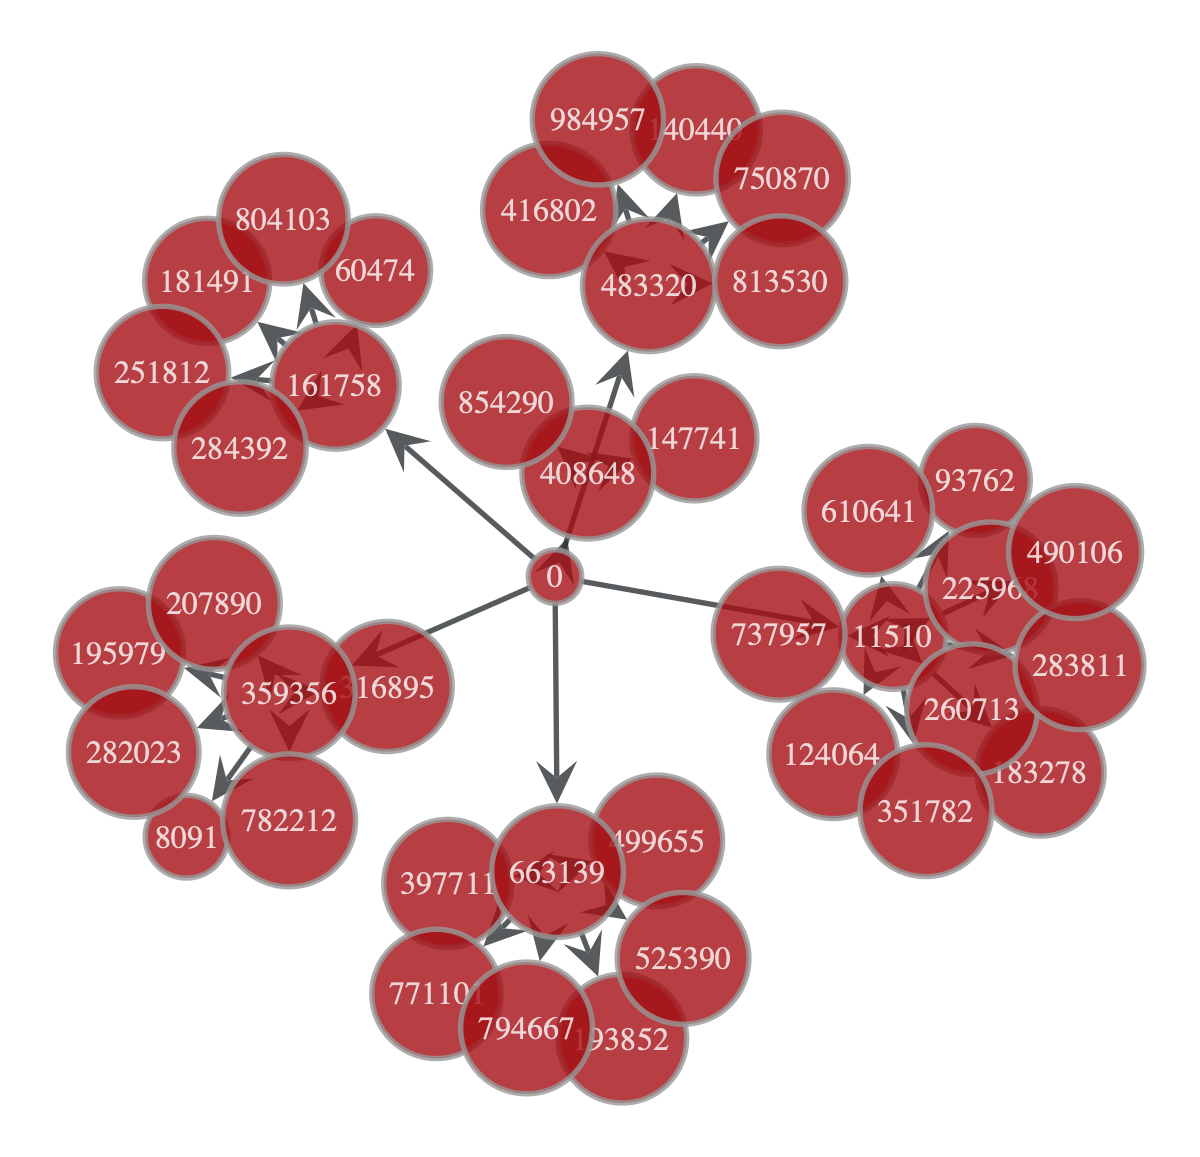

<GraphView object, directed, with 41 vertices and 40 edges, 12 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x173c37c80, at 0x67ec858e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x173c37c80, at 0x67ec855e0>, False), at 0x173c37c80>

In [25]:
superonion_medium.search(start_node_idx=0, 
                         max_dist=2, direction='downstream', 
                         node_text=None, show_plot=True)

These vertex indices aren't very informative. Let's create a way to show the node_label, as a conjunction of the layer and the node id.

In [26]:
[prop for prop in superonion_medium.graph.properties]

[('v', 'layer_hash'),
 ('v', 'node_id_hash'),
 ('v', 'node_prop_1'),
 ('v', 'node_prop_2'),
 ('v', 'node_prop_3'),
 ('v', 'node_prop_4'),
 ('v', 'node_prop_5'),
 ('v', 'node_prop_6'),
 ('v', 'node_prop_7'),
 ('v', 'node_prop_8'),
 ('v', 'node_prop_9'),
 ('v', 'node_prop_10'),
 ('e', 'edge_prop_1'),
 ('e', 'edge_prop_2'),
 ('e', 'edge_prop_3'),
 ('e', 'edge_prop_4'),
 ('e', 'edge_prop_5'),
 ('e', 'edge_prop_6'),
 ('e', 'edge_prop_7'),
 ('e', 'edge_prop_8'),
 ('e', 'edge_prop_9'),
 ('e', 'edge_prop_10')]

In [27]:
superonion_medium.create_node_label_property(prop_name='node_label')

Vertex property 'node_label' created successfully.


In [28]:
[prop for prop in superonion_medium.graph.properties]

[('v', 'layer_hash'),
 ('v', 'node_id_hash'),
 ('v', 'node_prop_1'),
 ('v', 'node_prop_2'),
 ('v', 'node_prop_3'),
 ('v', 'node_prop_4'),
 ('v', 'node_prop_5'),
 ('v', 'node_prop_6'),
 ('v', 'node_prop_7'),
 ('v', 'node_prop_8'),
 ('v', 'node_prop_9'),
 ('v', 'node_prop_10'),
 ('e', 'edge_prop_1'),
 ('e', 'edge_prop_2'),
 ('e', 'edge_prop_3'),
 ('e', 'edge_prop_4'),
 ('e', 'edge_prop_5'),
 ('e', 'edge_prop_6'),
 ('e', 'edge_prop_7'),
 ('e', 'edge_prop_8'),
 ('e', 'edge_prop_9'),
 ('e', 'edge_prop_10'),
 ('v', 'node_label')]

Downstream graph from node 0 contains 41 vertices and 40 edges.


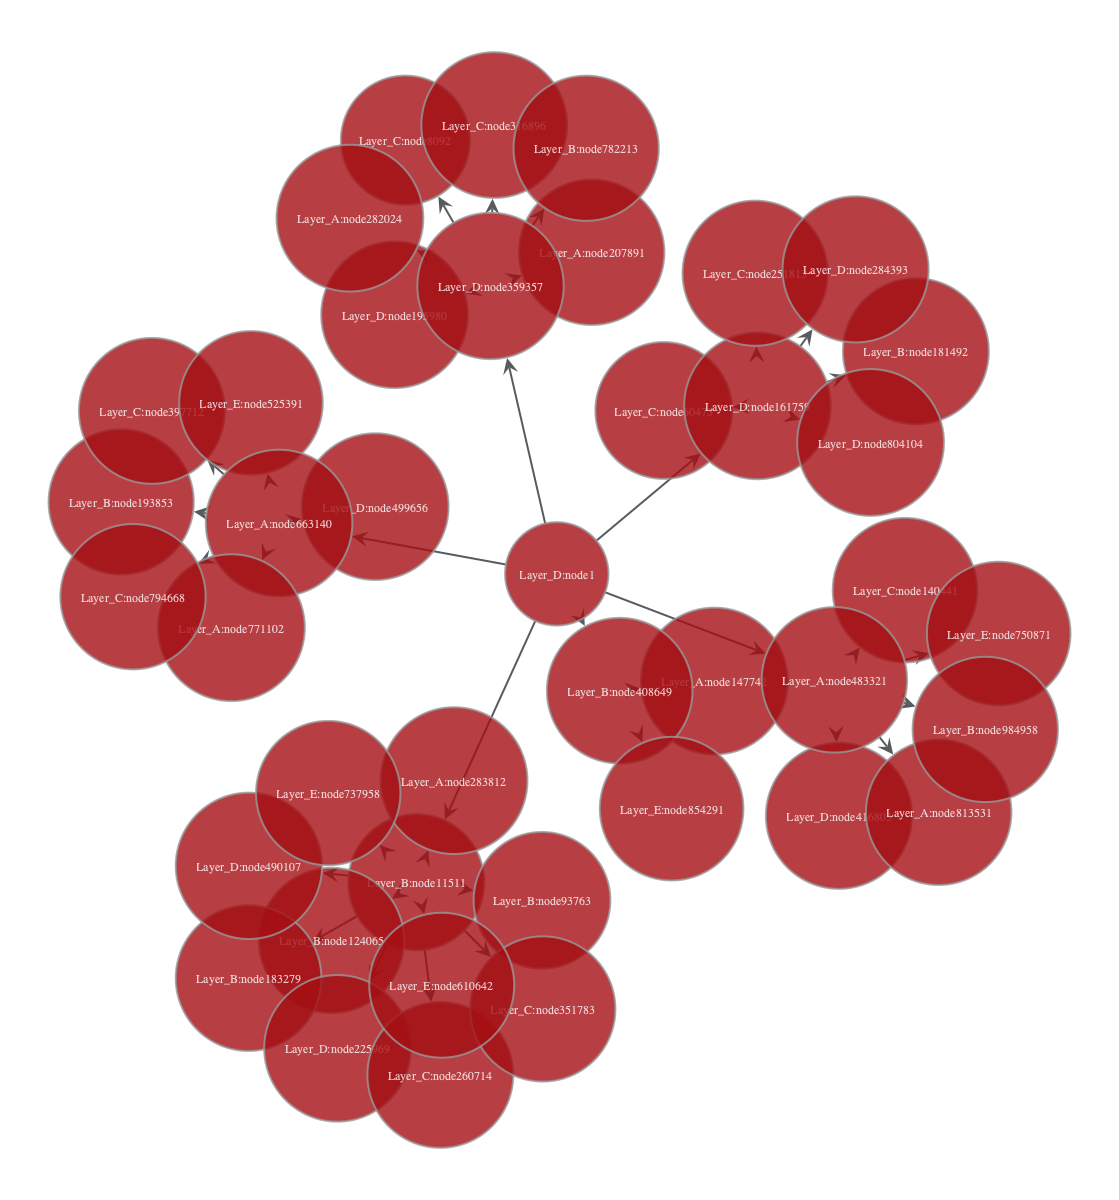

<GraphView object, directed, with 41 vertices and 40 edges, 13 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x66457f7a0, at 0x67ec84a10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x66457f7a0, at 0x67ec87b90>, False), at 0x66457f7a0>

In [29]:
superonion_medium.search(start_node_idx=0, 
                         max_dist=2, direction='downstream', 
                         node_text_prop='node_label', show_plot=True,
                         vertex_size=10) # Note how we can pass kwargs here to graph draw

In [30]:
superonion_medium.get_vertex_by_name_tuple(layer_name='Layer_D', node_id_str='node15')

<Vertex object with index '14' at 0x3a2f33c40>

Downstream graph from node 14 contains 28 vertices and 27 edges.


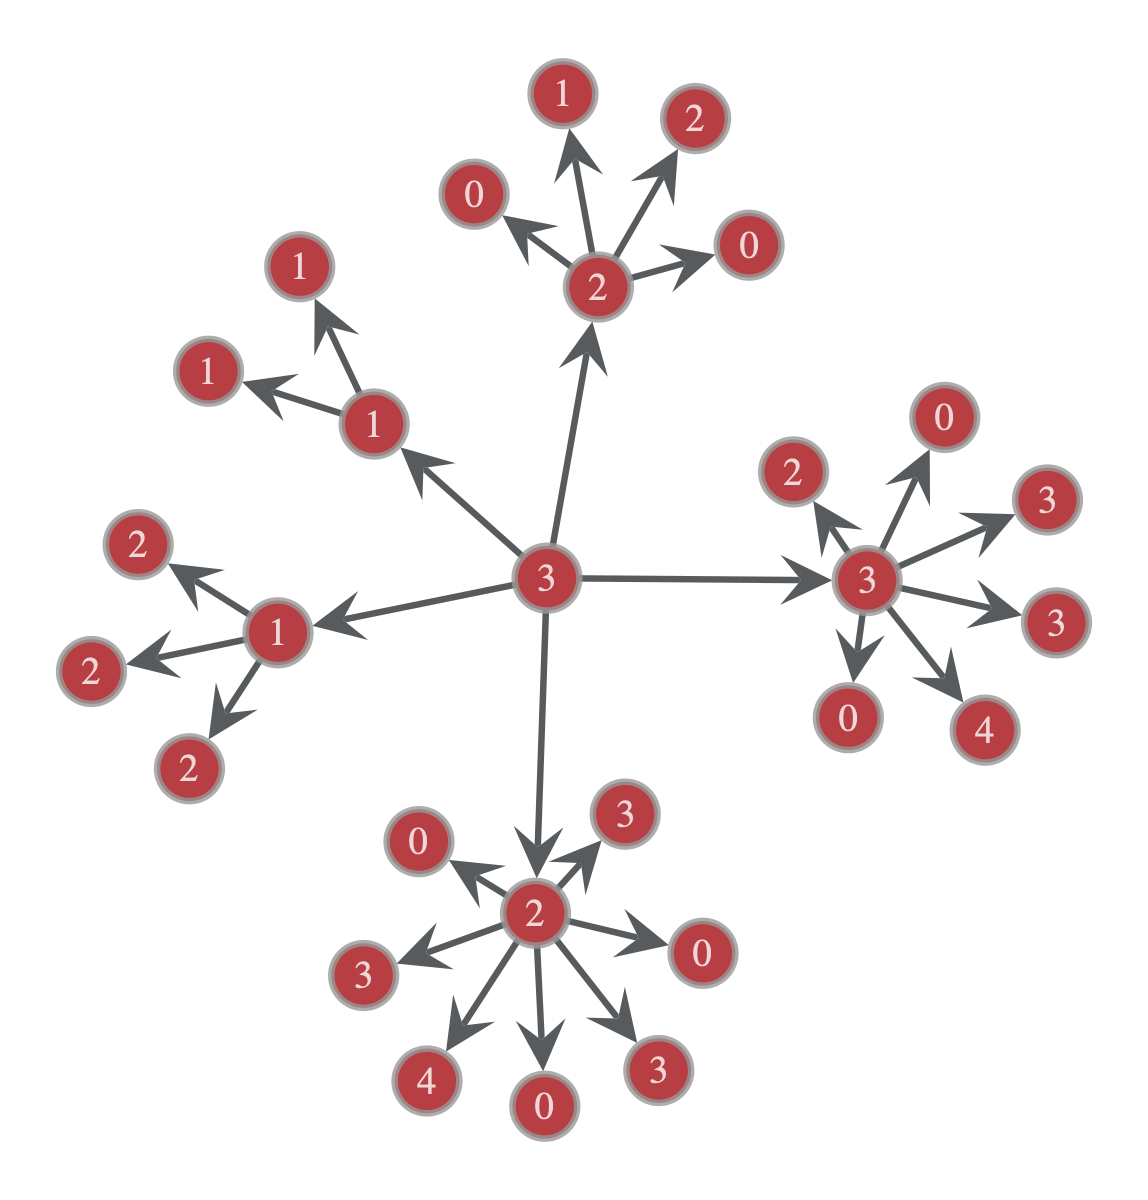

<GraphView object, directed, with 28 vertices and 27 edges, 13 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x67ec87380, at 0x656ec18e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x67ec87380, at 0x656ec1010>, False), at 0x67ec87380>

In [37]:
superonion_medium.search(start_node_idx=14, 
                         max_dist=2, direction='downstream', 
                         node_text_prop='layer_hash', show_plot=True)

In [32]:
superonion_medium.get_vertex_by_name_tuple(layer_name='Layer_D', node_id_str='node15').out_degree()

5

In [33]:
superonion_medium.graph.vertex(230069).out_degree()

6

Upstream graph from node 230069 contains 24 vertices and 23 edges.


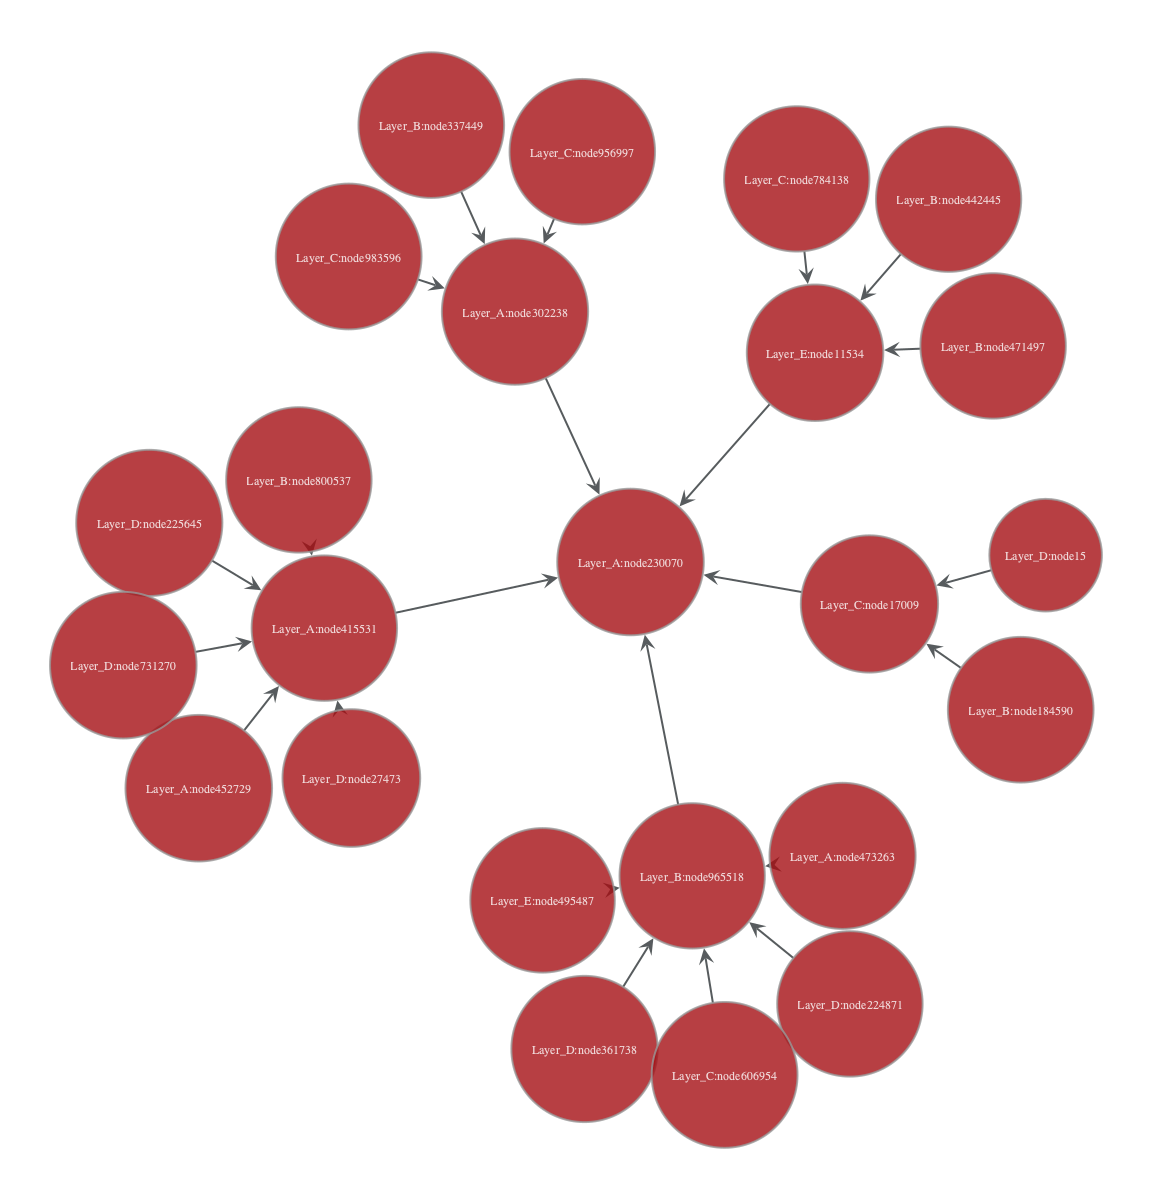

In [45]:
test_filter = superonion_medium.search(start_node_idx=230069, 
                         max_dist=2, direction='upstream', 
                         node_text_prop='node_label', show_plot=True,
                         vertex_size=10)

In [47]:
list(test_filter.properties)

[('v', 'layer_hash'),
 ('v', 'node_id_hash'),
 ('v', 'node_prop_1'),
 ('v', 'node_prop_2'),
 ('v', 'node_prop_3'),
 ('v', 'node_prop_4'),
 ('v', 'node_prop_5'),
 ('v', 'node_prop_6'),
 ('v', 'node_prop_7'),
 ('v', 'node_prop_8'),
 ('v', 'node_prop_9'),
 ('v', 'node_prop_10'),
 ('e', 'edge_prop_1'),
 ('e', 'edge_prop_2'),
 ('e', 'edge_prop_3'),
 ('e', 'edge_prop_4'),
 ('e', 'edge_prop_5'),
 ('e', 'edge_prop_6'),
 ('e', 'edge_prop_7'),
 ('e', 'edge_prop_8'),
 ('e', 'edge_prop_9'),
 ('e', 'edge_prop_10'),
 ('v', 'node_label')]

Upstream graph from node 230069 contains 24 vertices and 23 edges.


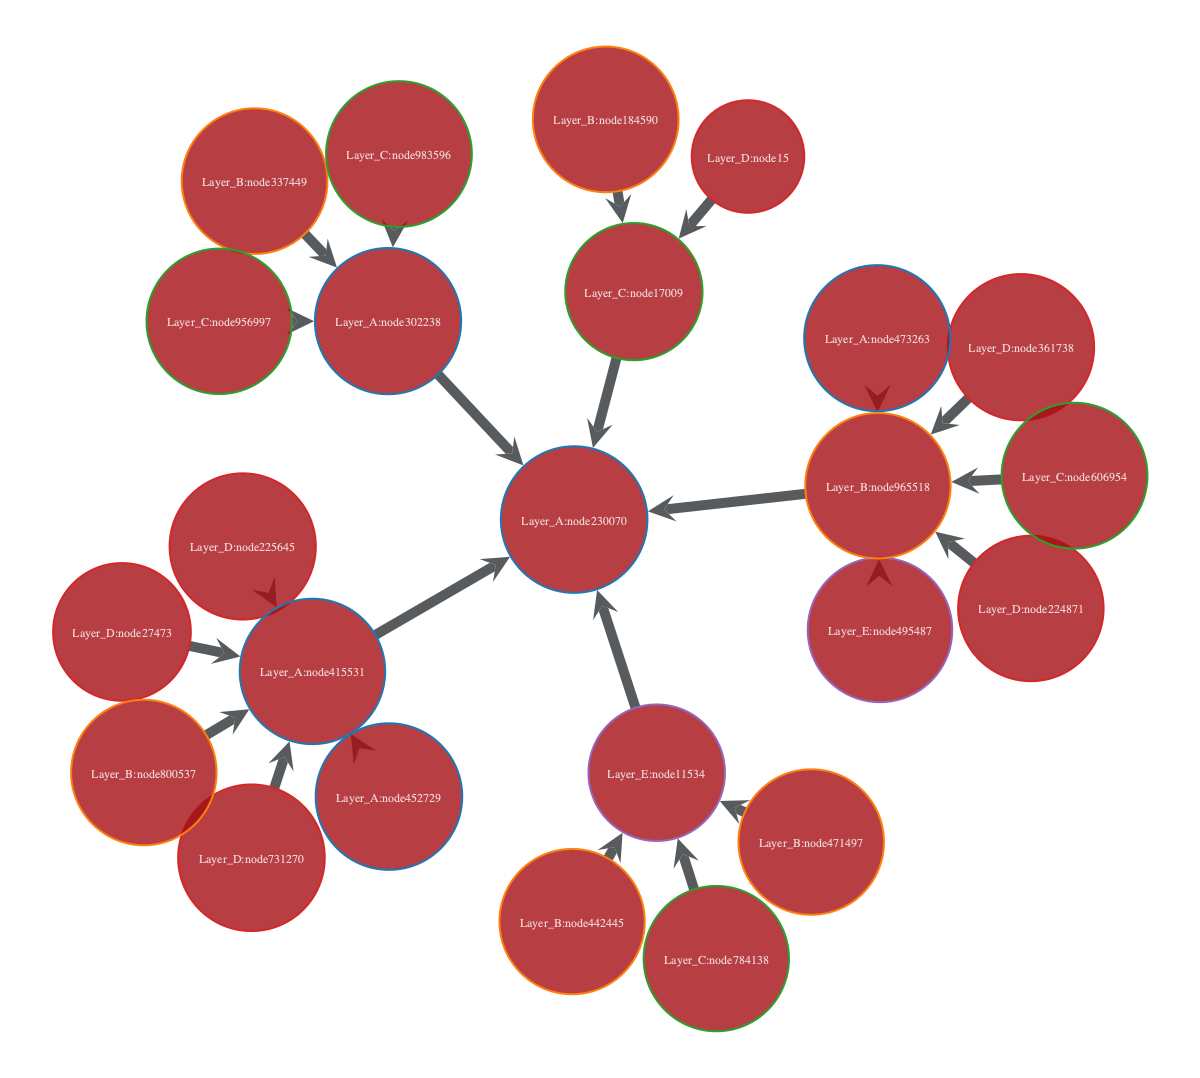

Upstream graph from node 230069 contains 24 vertices and 23 edges.


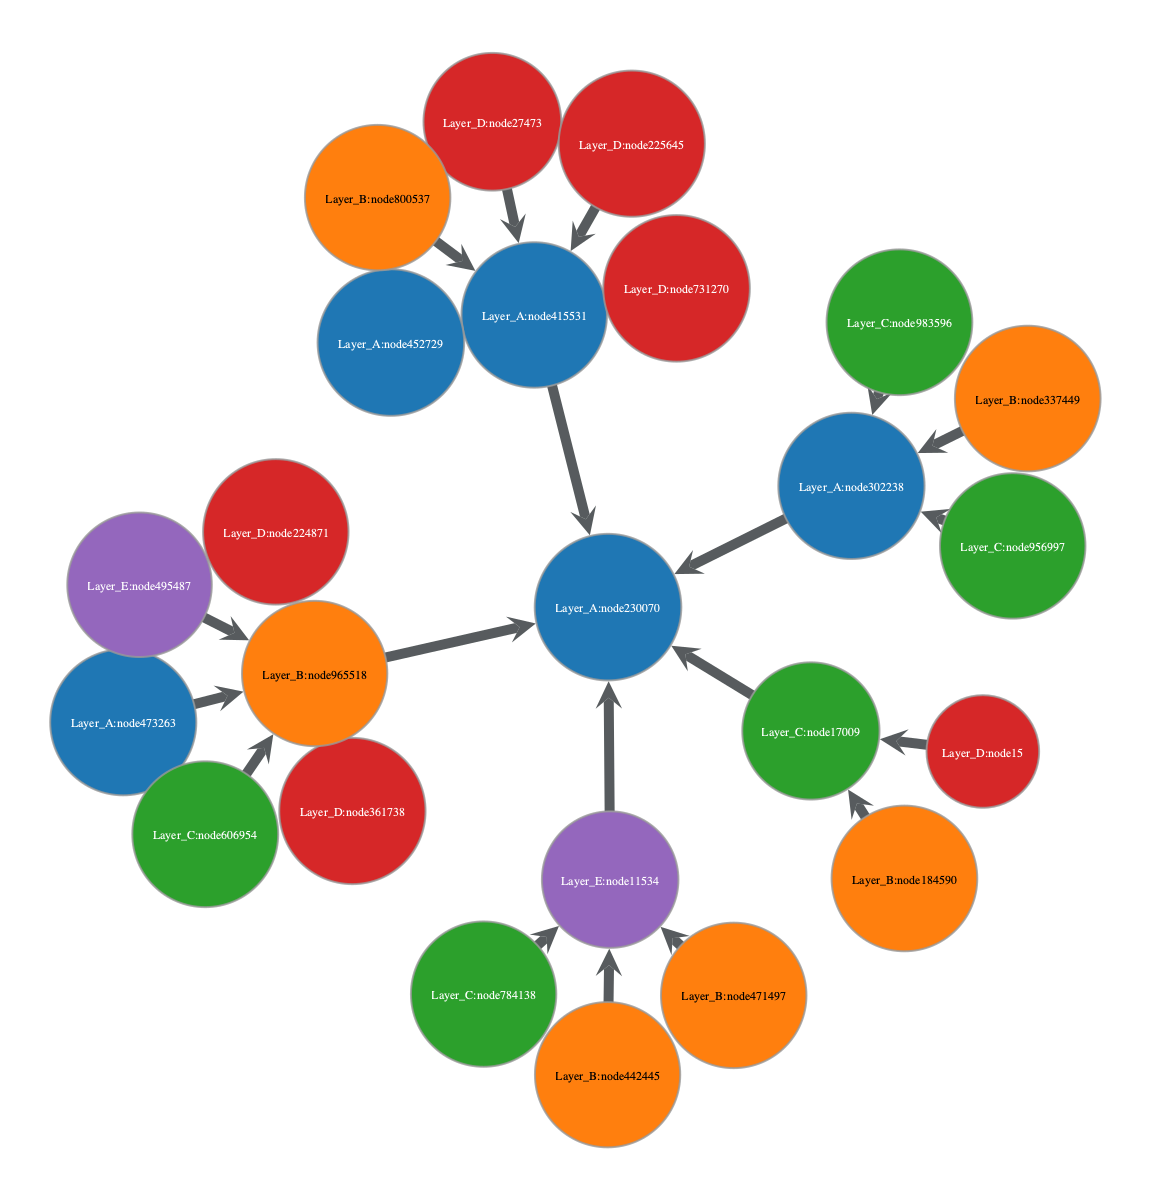

<GraphView object, directed, with 24 vertices and 23 edges, 13 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x63d92aba0, at 0x399d88710>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x63d92aba0, at 0x399d8bb90>, False), at 0x63d92aba0>

In [54]:
import lipinet.visualisation


colours = lipinet.visualisation.color_nodes(g=test_filter, prop_name='layer_hash', method='categorical')

superonion_medium.search(start_node_idx=230069, 
                         max_dist=2, direction='upstream', 
                         node_text_prop='node_label', show_plot=True,
                         vertex_size=10, 
                         vertex_color=colours,
                         edge_pen_width=5)

superonion_medium.search(start_node_idx=230069, 
                         max_dist=2, direction='upstream', 
                         node_text_prop='node_label', show_plot=True,
                         vertex_size=10, 
                         vertex_fill_color=colours,
                         edge_pen_width=5)

Note that we can also set the colours via the layer hash to continuous if we want

Upstream graph from node 230069 contains 24 vertices and 23 edges.


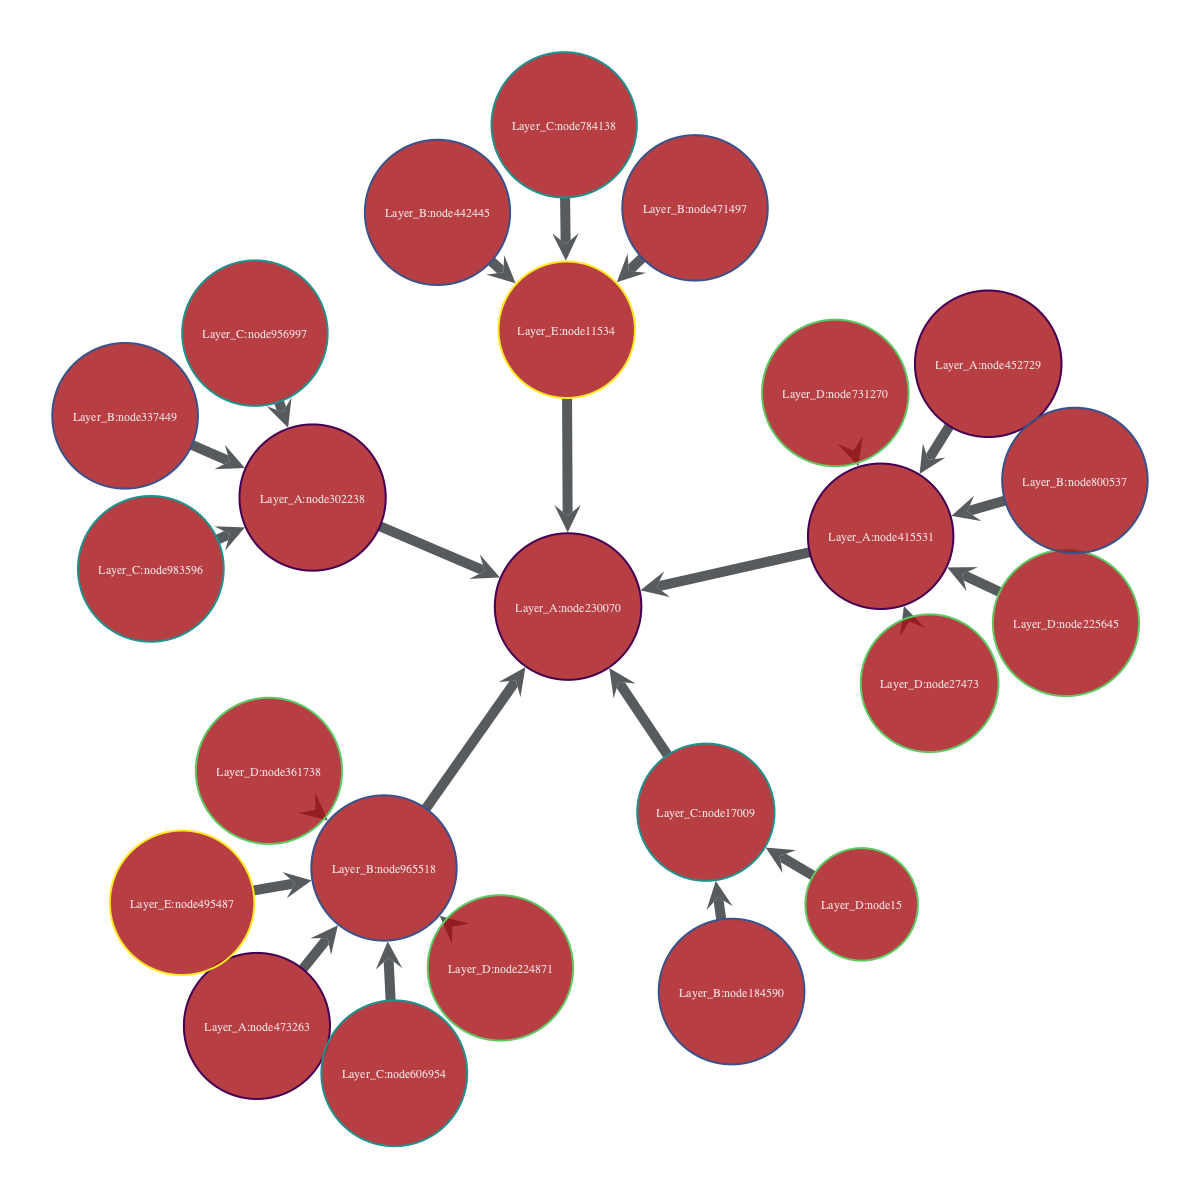

Upstream graph from node 230069 contains 24 vertices and 23 edges.


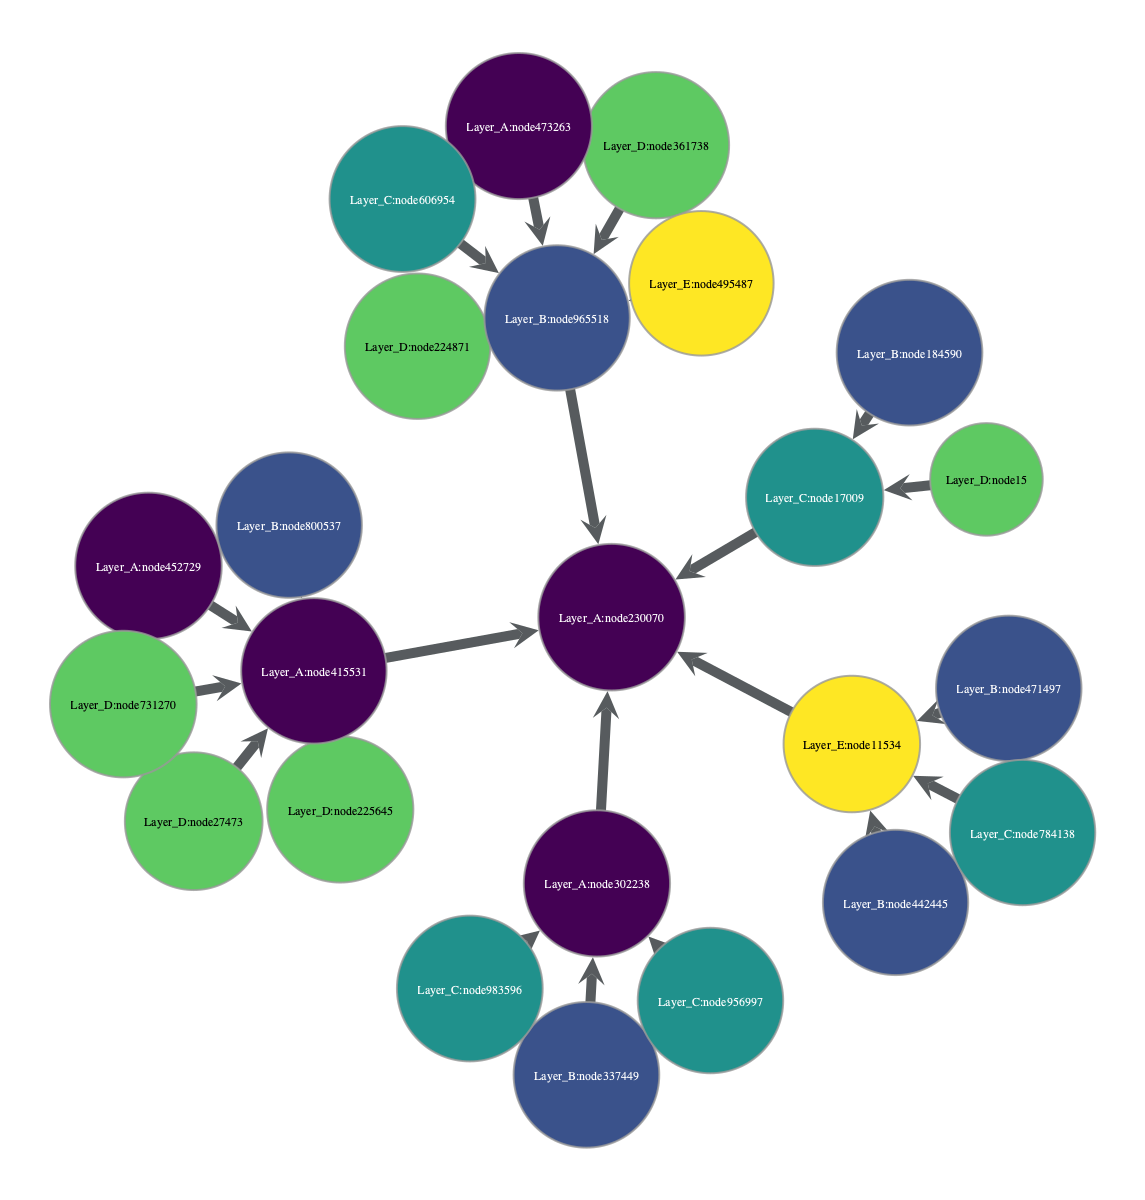

<GraphView object, directed, with 24 vertices and 23 edges, 13 internal vertex properties, 10 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x17b559f10, at 0x39760be60>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x17b559f10, at 0x39760bda0>, False), at 0x17b559f10>

In [55]:
colours = lipinet.visualisation.color_nodes(g=test_filter, prop_name='layer_hash', method='continuous')

superonion_medium.search(start_node_idx=230069, 
                         max_dist=2, direction='upstream', 
                         node_text_prop='node_label', show_plot=True,
                         vertex_size=10, 
                         vertex_color=colours,
                         edge_pen_width=5)

superonion_medium.search(start_node_idx=230069, 
                         max_dist=2, direction='upstream', 
                         node_text_prop='node_label', show_plot=True,
                         vertex_size=10, 
                         vertex_fill_color=colours,
                         edge_pen_width=5)

In [35]:
superonion_medium.graph.vertex(node_map[('Layer_D', 'node15')])

<Vertex object with index '14' at 0x3a2f320c0>

In [36]:
vtest = superonion_medium.graph.vertex(node_map[('Layer_D', 'node15')])
vtest.out_degree()

5